<a href="https://colab.research.google.com/github/naduhrin78/TensorFlowImplementations/blob/master/IRIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization


In [0]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf

In [0]:
print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.0.0-alpha0


In [0]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

# Train Data

In [0]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(os.path.basename(train_dataset_url), origin = train_dataset_url)

In [0]:
train_dataset = tf.data.experimental.make_csv_dataset(train_dataset_fp, 120, column_names=column_names, label_name=label_name, num_epochs=1)

In [0]:
train_features, train_labels = next(iter(train_dataset))
train_features = tf.stack(list(train_features.values()), axis=1)

# Test Data

In [0]:
test_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_data_fp = tf.keras.utils.get_file(os.path.basename(test_dataset_url), origin=test_dataset_url)

In [0]:
test_dataset = tf.data.experimental.make_csv_dataset(test_data_fp, 30, column_names=column_names, label_name=label_name, num_epochs=1)

In [0]:
test_features, test_labels = next(iter(test_dataset))
test_features = tf.stack(list(test_features.values()), axis=1)

In [0]:
tra = []
trl = []
tsa = []
tsl = []

# Model

In [0]:
class IRISModel(tf.keras.Model):
    def __init__(self):
        super(IRISModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(10, activation='relu', input_shape=(4,))
        self.dense2 = tf.keras.layers.Dense(10, activation='relu')
        self.dense3 = tf.keras.layers.Dense(3, activation='softmax')
        self.loss_obj = tf.keras.losses.SparseCategoricalCrossentropy()
        self.optimizer = tf.keras.optimizers.Adam()
        self.train_loss = tf.metrics.Mean()
        self.train_accuracy = tf.metrics.SparseCategoricalAccuracy()
        self.test_loss = tf.metrics.Mean()
        self.test_accuracy = tf.metrics.SparseCategoricalAccuracy()
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)
    
    @tf.function
    def train_step(self, features, label):
        with tf.GradientTape() as tape:
            pred = self(features)
            loss = self.loss_obj(label, pred)
        
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.train_loss(loss)
        self.train_accuracy(label, pred)
    
    @tf.function
    def test_step(self, features, label):
        pred = self(features)        
        loss = self.loss_obj(label, pred)
        
        self.test_loss(loss)
        self.test_accuracy(label, pred)
        
    def fit(self, x_train, y_train, x_test, y_test, epochs=5):
        train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(10)
        test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(10)
        
        for epoch in range(epochs):
            for features, label in train_ds:
                self.train_step(features, label)
                
            train_loss = self.train_loss.result()
            train_acc =self.train_accuracy.result()
            
            trl.append(train_loss)
            tra.append(train_acc)
            
            for features, label in test_ds:
                self.test_step(features, label)
                
            test_loss = self.test_loss.result()
            test_acc = self.test_accuracy.result()
            
            tsl.append(test_loss)
            tsa.append(test_acc)
            
            template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
            
            if epoch%50 == 0 or epoch == epochs-1:
                print(template.format(epoch,
                                  train_loss,
                                  train_acc * 100,
                                  test_loss,
                                  test_acc * 100))

In [0]:
model = IRISModel()

# Assessment

In [33]:
model.fit(train_features, train_labels, test_features, test_labels, epochs=200)

Epoch 0, Loss: 1.1620203256607056, Accuracy: 30.000001907348633, Test Loss: 1.0834051370620728, Test Accuracy: 46.66666793823242
Epoch 50, Loss: 0.6435810327529907, Accuracy: 75.86601257324219, Test Loss: 0.7047508358955383, Test Accuracy: 67.90849304199219
Epoch 100, Loss: 0.43111151456832886, Accuracy: 86.29537963867188, Test Loss: 0.469341516494751, Test Accuracy: 82.07920837402344
Epoch 150, Loss: 0.32503998279571533, Accuracy: 90.28145599365234, Test Loss: 0.34871044754981995, Test Accuracy: 86.90949249267578
Epoch 199, Loss: 0.26605212688446045, Accuracy: 92.25416564941406, Test Loss: 0.281833291053772, Test Accuracy: 89.30000305175781


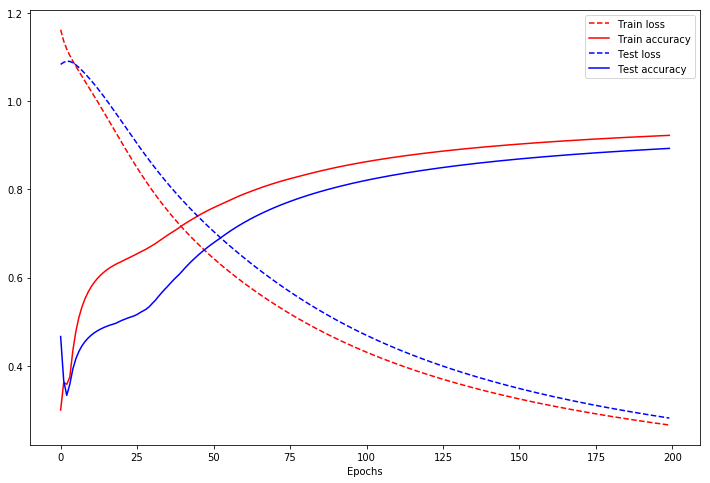

In [34]:
plt.figure(figsize=(12, 8))
plt.plot(list(range(200)), [t.numpy() for t in trl], 'r--', label='Train loss')
plt.plot(list(range(200)), [t.numpy() for t in tra], 'r', label='Train accuracy')
plt.plot(list(range(200)), [t.numpy() for t in tsl], 'b--', label='Test loss')
plt.plot(list(range(200)), [t.numpy() for t in tsa], 'b', label='Test accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()
